### This file contains the post-processing code for the sensitivity analysis of the proposed method with different $l_q$ settings and Naive21.

1. `/Reproduction/Analysis-lq/Metrics.xlsx` contains the metrics for each data split of the proposed method with different $l_q$ settings and Naive21.

2. `/Reproduction/Analysis-lq/Metrics/` contains the metrics for each test well inside each data split of the proposed method with different $l_q$ settings and Naive21.

3. `/Reproduction/Analysis-lq/MAPE/`, `/Reproduction/Analysis-lq/MAE/`, and `/Reproduction/Analysis-lq/MR/` contains the summary of MAPE, MAE, and MR of of the proposed method with different $l_q$ settings and Naive21. These files will be used for the statistical inference.

4. The statistical inference results will be printed out during execution. `Passed` means the corresponding null hypothesis is rejected. `Failed` means the corresponding null hypothesis cannot be rejected.

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick

pd.options.mode.chained_assignment = None

In [2]:
# Get the current directory.
current_dir = os.getcwd()

# Set up random seeds for data splitting.
split_rs = [290, 150, 266, 78, 148, 133, 155, 135, 178, 241]

# Set up a directory to be used.
os.makedirs(current_dir+'/Analysis-lq/Metrics/')

# Raw data corresponding to lq=7 and lq=14 need to be recitied to fit raw data corresponding to lq=21.
def rectify_df_1(df):
    # This function aligns lq7-1, lq7-4, lq14-1 and lq14-4 data to lq21 data.
    # `df` is the data to be rectified.

    reopenings = [0]
    for i in range(len(df)-1):
        if (df['Mark'][i] == 'forecast') and (df['Mark'][i+1] == 'initial'):
            reopenings.append(i+1)
    for i in range(len(reopenings)):
        df['Mark'][reopenings[i]:reopenings[i]+21] = 'initial'
    df['TrueCumu'] = (df['True']*df['t']).cumsum()
    df['PredCumu'] = (df['Pred']*df['t']).cumsum()

    df = df[df['Mark'] == 'forecast'].reset_index(drop=True)

    return df

def rectify_df_2(df_21, df, length):
    # This function aligns lq7-2, lq7-3, lq7-5, lq7-6, lq14-2, lq-14-3, lq14-5, and lq-14-6 data to lq21 data.
    # `df_21` is lq21 data. 
    # `df` is the data to be rectified and `length` is the associated lq value (7 or 14).

    reopenings_21 = [0]
    for i in range(len(df_21)-1):
        if (df_21['Mark'][i] == 'forecast') and (df_21['Mark'][i+1] == 'initial'):
            reopenings_21.append(i+1)
    reopenings_21.append(len(df_21))

    reopenings = [0]
    for i in range(len(df)-1):
        if (df['Mark'][i] == 'forecast') and (df['Mark'][i+1] == 'initial'):
            reopenings.append(i+1)
    reopenings.append(len(df))

    result_dfs = []
    for i in range(len(reopenings)-1):
        result_dfs.append(df_21.iloc[reopenings_21[i]:reopenings_21[i]+21])
        result_dfs.append(df.iloc[(reopenings[i]+length):reopenings[i+1]])
    result_df = pd.concat(result_dfs)

    result_df['TrueCumu'] = (result_df['True']*result_df['t']).cumsum()
    result_df['PredCumu'] = (result_df['Pred']*result_df['t']).cumsum()

    result_df = result_df[result_df['Mark'] == 'forecast'].reset_index(drop=True)
    
    return result_df

### Summary of the sensitivity analysis (Section 3.4)

In [3]:
omape_lq71, omape_lq72, omape_lq73, omape_lq74, omape_lq75, omape_lq76, omape_lq141, omape_lq142, omape_lq143, omape_lq144, omape_lq145, omape_lq146, omape_lq21, omape_naive = [], [], [], [], [], [], [], [], [], [], [], [], [], []
omae_lq71, omae_lq72, omae_lq73, omae_lq74, omae_lq75, omae_lq76, omae_lq141, omae_lq142, omae_lq143, omae_lq144, omae_lq145, omae_lq146, omae_lq21, omae_naive = [], [], [], [], [], [], [], [], [], [], [], [], [], []
omr_lq71, omr_lq72, omr_lq73, omr_lq74, omr_lq75, omr_lq76, omr_lq141, omr_lq142, omr_lq143, omr_lq144, omr_lq145, omr_lq146, omr_lq21, omr_naive = [], [], [], [], [], [], [], [], [], [], [], [], [], []

for rs in split_rs:

    path_result_lq21 = current_dir+'/Results/lq/lq21/'+str(rs)+'-ResultData/'
    files_result_lq21 = sorted(os.listdir(path_result_lq21))

    path_result_lq71 = current_dir+'/Results/lq/lq7-1/'+str(rs)+'-ResultData/'
    files_result_lq71 = sorted(os.listdir(path_result_lq71))

    path_result_lq72 = current_dir+'/Results/lq/lq7-2/'+str(rs)+'-ResultData/'
    files_result_lq72 = sorted(os.listdir(path_result_lq72))

    path_result_lq73 = current_dir+'/Results/lq/lq7-3/'+str(rs)+'-ResultData/'
    files_result_lq73 = sorted(os.listdir(path_result_lq73))

    path_result_lq74 = current_dir+'/Results/lq/lq7-4/'+str(rs)+'-ResultData/'
    files_result_lq74 = sorted(os.listdir(path_result_lq74))

    path_result_lq75 = current_dir+'/Results/lq/lq7-5/'+str(rs)+'-ResultData/'
    files_result_lq75 = sorted(os.listdir(path_result_lq75))

    path_result_lq76 = current_dir+'/Results/lq/lq7-6/'+str(rs)+'-ResultData/'
    files_result_lq76 = sorted(os.listdir(path_result_lq76))

    path_result_lq141 = current_dir+'/Results/lq/lq14-1/'+str(rs)+'-ResultData/'
    files_result_lq141 = sorted(os.listdir(path_result_lq141))

    path_result_lq142 = current_dir+'/Results/lq/lq14-2/'+str(rs)+'-ResultData/'
    files_result_lq142 = sorted(os.listdir(path_result_lq142))

    path_result_lq143 = current_dir+'/Results/lq/lq14-3/'+str(rs)+'-ResultData/'
    files_result_lq143 = sorted(os.listdir(path_result_lq143))

    path_result_lq144 = current_dir+'/Results/lq/lq14-4/'+str(rs)+'-ResultData/'
    files_result_lq144 = sorted(os.listdir(path_result_lq144))

    path_result_lq145 = current_dir+'/Results/lq/lq14-5/'+str(rs)+'-ResultData/'
    files_result_lq145 = sorted(os.listdir(path_result_lq145))

    path_result_lq146 = current_dir+'/Results/lq/lq14-6/'+str(rs)+'-ResultData/'
    files_result_lq146 = sorted(os.listdir(path_result_lq146))

    path_result_naive = current_dir+'/Results/lq/Naive21/'+str(rs)+'-ResultData/'
    files_result_naive = sorted(os.listdir(path_result_naive))

    mape_lq21_this_rs, mape_lq71_this_rs, mape_lq72_this_rs, mape_lq73_this_rs, mape_lq74_this_rs, mape_lq75_this_rs, mape_lq76_this_rs, mape_lq141_this_rs, mape_lq142_this_rs, mape_lq143_this_rs, mape_lq144_this_rs, mape_lq145_this_rs, mape_lq146_this_rs, mape_naive_this_rs = [], [], [], [], [], [], [], [], [], [], [], [], [], []
    mae_lq21_this_rs, mae_lq71_this_rs, mae_lq72_this_rs, mae_lq73_this_rs, mae_lq74_this_rs, mae_lq75_this_rs, mae_lq76_this_rs, mae_lq141_this_rs, mae_lq142_this_rs, mae_lq143_this_rs, mae_lq144_this_rs, mae_lq145_this_rs, mae_lq146_this_rs, mae_naive_this_rs = [], [], [], [], [], [], [], [], [], [], [], [], [], []
    mr_lq21_this_rs, mr_lq71_this_rs, mr_lq72_this_rs, mr_lq73_this_rs, mr_lq74_this_rs, mr_lq75_this_rs, mr_lq76_this_rs, mr_lq141_this_rs, mr_lq142_this_rs, mr_lq143_this_rs, mr_lq144_this_rs, mr_lq145_this_rs, mr_lq146_this_rs, mr_naive_this_rs = [], [], [], [], [], [], [], [], [], [], [], [], [], []
    lengths_this_rs = []
    wells_this_rs = []

    for k in range(len(files_result_lq21)):

        ## lq 21
        df_lq21 = pd.read_excel(path_result_lq21+files_result_lq21[k], header = 0, sheet_name = 0)
        df_lq21 = df_lq21[df_lq21['Mark'] == 'forecast'].reset_index(drop=True)
        col_lq21 = df_lq21['PredCumu']

        col_true = df_lq21['TrueCumu']
        lengths_this_rs.append(len(col_true))
        wells_this_rs.append(files_result_lq21[k][11:-5])

        ## Reset df_lq21
        df_lq21 = pd.read_excel(path_result_lq21+files_result_lq21[k], header = 0, sheet_name = 0)

        ## lq 7-1
        df_lq71 = pd.read_excel(path_result_lq71+files_result_lq71[k], header = 0, sheet_name = 0)
        df_lq71 = rectify_df_1(df_lq71)
        col_lq71 = df_lq71['PredCumu']

        ## lq 7-2
        df_lq72 = pd.read_excel(path_result_lq72+files_result_lq72[k], header = 0, sheet_name = 0)
        df_lq72 = rectify_df_2(df_lq21, df_lq72, 7)
        col_lq72 = df_lq72['PredCumu']

        ## lq 7-3
        df_lq73 = pd.read_excel(path_result_lq73+files_result_lq73[k], header = 0, sheet_name = 0)
        df_lq73 = rectify_df_2(df_lq21, df_lq73, 7)
        col_lq73 = df_lq73['PredCumu']

        ## lq 7-4
        df_lq74 = pd.read_excel(path_result_lq74+files_result_lq74[k], header = 0, sheet_name = 0)
        df_lq74 = rectify_df_1(df_lq74)
        col_lq74 = df_lq74['PredCumu']

        ## lq 7-5
        df_lq75 = pd.read_excel(path_result_lq75+files_result_lq75[k], header = 0, sheet_name = 0)
        df_lq75 = rectify_df_2(df_lq21, df_lq75, 7)
        col_lq75 = df_lq75['PredCumu']

        ## lq 7-6
        df_lq76 = pd.read_excel(path_result_lq76+files_result_lq76[k], header = 0, sheet_name = 0)
        df_lq76 = rectify_df_2(df_lq21, df_lq76, 7)
        col_lq76 = df_lq76['PredCumu']

        ## lq 14-1
        df_lq141 = pd.read_excel(path_result_lq141+files_result_lq141[k], header = 0, sheet_name = 0)
        df_lq141 = rectify_df_1(df_lq141)
        col_lq141 = df_lq141['PredCumu']

        ## lq 14-2
        df_lq142 = pd.read_excel(path_result_lq142+files_result_lq142[k], header = 0, sheet_name = 0)
        df_lq142 = rectify_df_2(df_lq21, df_lq142, 14)
        col_lq142 = df_lq142['PredCumu']

        ## lq 14-3
        df_lq143 = pd.read_excel(path_result_lq143+files_result_lq143[k], header = 0, sheet_name = 0)
        df_lq143 = rectify_df_2(df_lq21, df_lq143, 14)
        col_lq143 = df_lq143['PredCumu']

        ## lq 14-4
        df_lq144 = pd.read_excel(path_result_lq144+files_result_lq144[k], header = 0, sheet_name = 0)
        df_lq144 = rectify_df_1(df_lq144)
        col_lq144 = df_lq144['PredCumu']

        ## lq 14-5
        df_lq145 = pd.read_excel(path_result_lq145+files_result_lq145[k], header = 0, sheet_name = 0)
        df_lq145 = rectify_df_2(df_lq21, df_lq145, 14)
        col_lq145 = df_lq145['PredCumu']

        ## lq 14-6
        df_lq146 = pd.read_excel(path_result_lq146+files_result_lq146[k], header = 0, sheet_name = 0)
        df_lq146 = rectify_df_2(df_lq21, df_lq146, 14)
        col_lq146 = df_lq146['PredCumu']

        ## Naive21
        df_naive = pd.read_excel(path_result_naive+files_result_naive[k], header = 0, sheet_name = 0)
        df_naive = df_naive[df_naive['Mark']=='forecast'].reset_index(drop=True)
        col_naive = df_naive['PredCumu']

        ape_lq71_this_well = abs(col_lq71-col_true)/col_true
        ape_lq72_this_well = abs(col_lq72-col_true)/col_true
        ape_lq73_this_well = abs(col_lq73-col_true)/col_true
        ape_lq74_this_well = abs(col_lq74-col_true)/col_true
        ape_lq75_this_well = abs(col_lq75-col_true)/col_true
        ape_lq76_this_well = abs(col_lq76-col_true)/col_true
        ape_lq141_this_well = abs(col_lq141-col_true)/col_true
        ape_lq142_this_well = abs(col_lq142-col_true)/col_true
        ape_lq143_this_well = abs(col_lq143-col_true)/col_true
        ape_lq144_this_well = abs(col_lq144-col_true)/col_true
        ape_lq145_this_well = abs(col_lq145-col_true)/col_true
        ape_lq146_this_well = abs(col_lq146-col_true)/col_true
        ape_lq21_this_well = abs(col_lq21-col_true)/col_true
        ape_naive_this_well = abs(col_naive-col_true)/col_true

        mape_lq71_this_rs.append(np.mean(ape_lq71_this_well))
        mape_lq72_this_rs.append(np.mean(ape_lq72_this_well))
        mape_lq73_this_rs.append(np.mean(ape_lq73_this_well))
        mape_lq74_this_rs.append(np.mean(ape_lq74_this_well))
        mape_lq75_this_rs.append(np.mean(ape_lq75_this_well))
        mape_lq76_this_rs.append(np.mean(ape_lq76_this_well))
        mape_lq141_this_rs.append(np.mean(ape_lq141_this_well))
        mape_lq142_this_rs.append(np.mean(ape_lq142_this_well))
        mape_lq143_this_rs.append(np.mean(ape_lq143_this_well))
        mape_lq144_this_rs.append(np.mean(ape_lq144_this_well))
        mape_lq145_this_rs.append(np.mean(ape_lq145_this_well))
        mape_lq146_this_rs.append(np.mean(ape_lq146_this_well))
        mape_lq21_this_rs.append(np.mean(ape_lq21_this_well))
        mape_naive_this_rs.append(np.mean(ape_naive_this_well))

        ae_lq71_this_well = abs(col_lq71-col_true)
        ae_lq72_this_well = abs(col_lq72-col_true)
        ae_lq73_this_well = abs(col_lq73-col_true)
        ae_lq74_this_well = abs(col_lq74-col_true)
        ae_lq75_this_well = abs(col_lq75-col_true)
        ae_lq76_this_well = abs(col_lq76-col_true)
        ae_lq141_this_well = abs(col_lq141-col_true)
        ae_lq142_this_well = abs(col_lq142-col_true)
        ae_lq143_this_well = abs(col_lq143-col_true)
        ae_lq144_this_well = abs(col_lq144-col_true)
        ae_lq145_this_well = abs(col_lq145-col_true)
        ae_lq146_this_well = abs(col_lq146-col_true)
        ae_lq21_this_well = abs(col_lq21-col_true)
        ae_naive_this_well = abs(col_naive-col_true)

        mae_lq71_this_rs.append(np.mean(ae_lq71_this_well))
        mae_lq72_this_rs.append(np.mean(ae_lq72_this_well))
        mae_lq73_this_rs.append(np.mean(ae_lq73_this_well))
        mae_lq74_this_rs.append(np.mean(ae_lq74_this_well))
        mae_lq75_this_rs.append(np.mean(ae_lq75_this_well))
        mae_lq76_this_rs.append(np.mean(ae_lq76_this_well))
        mae_lq141_this_rs.append(np.mean(ae_lq141_this_well))
        mae_lq142_this_rs.append(np.mean(ae_lq142_this_well))
        mae_lq143_this_rs.append(np.mean(ae_lq143_this_well))
        mae_lq144_this_rs.append(np.mean(ae_lq144_this_well))
        mae_lq145_this_rs.append(np.mean(ae_lq145_this_well))
        mae_lq146_this_rs.append(np.mean(ae_lq146_this_well))
        mae_lq21_this_rs.append(np.mean(ae_lq21_this_well))
        mae_naive_this_rs.append(np.mean(ae_naive_this_well))

        all_errors_this_well = pd.DataFrame({'lq7-1':ape_lq71_this_well, 'lq7-2':ape_lq72_this_well, 'lq7-3':ape_lq73_this_well, 'lq7-4':ape_lq74_this_well, 'lq7-5':ape_lq75_this_well, 'lq7-6':ape_lq76_this_well, 
                                             'lq14-1':ape_lq141_this_well, 'lq14-2':ape_lq142_this_well, 'lq14-3':ape_lq143_this_well, 'lq14-4':ape_lq144_this_well, 'lq14-5':ape_lq145_this_well, 'lq14-6':ape_lq146_this_well, 
                                             'lq21':ape_lq21_this_well, 'Naive21':ape_naive_this_well})
        rank = pd.DataFrame(np.nan, index=list(all_errors_this_well.index), columns=all_errors_this_well.columns)
        for j in range(len(all_errors_this_well)):
            rank.iloc[j,:] = scipy.stats.rankdata(all_errors_this_well.iloc[j,:], method='average')

        mr_lq71_this_rs.append(np.mean(rank['lq7-1']))
        mr_lq72_this_rs.append(np.mean(rank['lq7-2']))
        mr_lq73_this_rs.append(np.mean(rank['lq7-3']))
        mr_lq74_this_rs.append(np.mean(rank['lq7-4']))
        mr_lq75_this_rs.append(np.mean(rank['lq7-5']))
        mr_lq76_this_rs.append(np.mean(rank['lq7-6']))
        mr_lq141_this_rs.append(np.mean(rank['lq14-1']))
        mr_lq142_this_rs.append(np.mean(rank['lq14-2']))
        mr_lq143_this_rs.append(np.mean(rank['lq14-3']))
        mr_lq144_this_rs.append(np.mean(rank['lq14-4']))
        mr_lq145_this_rs.append(np.mean(rank['lq14-5']))
        mr_lq146_this_rs.append(np.mean(rank['lq14-6']))
        mr_lq21_this_rs.append(np.mean(rank['lq21']))
        mr_naive_this_rs.append(np.mean(rank['Naive21']))

    result_this_rs = pd.DataFrame({'lq7-1_mape':mape_lq71_this_rs, 'lq7-2_mape':mape_lq72_this_rs, 'lq7-3_mape':mape_lq73_this_rs, 'lq7-4_mape':mape_lq74_this_rs, 'lq7-5_mape':mape_lq75_this_rs, 'lq7-6_mape':mape_lq76_this_rs, 
                                   'lq14-1_mape':mape_lq141_this_rs, 'lq14-2_mape':mape_lq142_this_rs, 'lq14-3_mape':mape_lq143_this_rs, 'lq14-4_mape':mape_lq144_this_rs, 'lq14-5_mape':mape_lq145_this_rs, 'lq14-6_mape':mape_lq146_this_rs, 
                                   'lq21_mape':mape_lq21_this_rs, 'Naive21_mape':mape_naive_this_rs,
                                   'lq7-1_mae':mae_lq71_this_rs, 'lq7-2_mae':mae_lq72_this_rs, 'lq7-3_mae':mae_lq73_this_rs, 'lq7-4_mae':mae_lq74_this_rs, 'lq7-5_mae':mae_lq75_this_rs, 'lq7-6_mae':mae_lq76_this_rs, 
                                   'lq14-1_mae':mae_lq141_this_rs, 'lq14-2_mae':mae_lq142_this_rs, 'lq14-3_mae':mae_lq143_this_rs, 'lq14-4_mae':mae_lq144_this_rs, 'lq14-5_mae':mae_lq145_this_rs, 'lq14-6_mae':mae_lq146_this_rs, 
                                   'lq21_mae':mae_lq21_this_rs, 'Naive21_mae':mae_naive_this_rs,
                                   'lq7-1_mr':mr_lq71_this_rs, 'lq7-2_mr':mr_lq72_this_rs, 'lq7-3_mr':mr_lq73_this_rs, 'lq7-4_mr':mr_lq74_this_rs, 'lq7-5_mr':mr_lq75_this_rs, 'lq7-6_mr':mr_lq76_this_rs, 
                                   'lq14-1_mr':mr_lq141_this_rs, 'lq14-2_mr':mr_lq142_this_rs, 'lq14-3_mr':mr_lq143_this_rs, 'lq14-4_mr':mr_lq144_this_rs, 'lq14-5_mr':mr_lq145_this_rs, 'lq14-6_mr':mr_lq146_this_rs, 
                                   'lq21_mr':mr_lq21_this_rs, 'Naive21_mr':mr_naive_this_rs,
                                   'Length':lengths_this_rs, 'Well':wells_this_rs})
    writer = pd.ExcelWriter(current_dir+'/Analysis-lq/Metrics/Metrics-'+str(rs)+'.xlsx')
    result_this_rs.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()

    omape_lq71_this_rs = np.sum(result_this_rs['lq7-1_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_lq71_this_rs = np.sum(result_this_rs['lq7-1_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_lq71_this_rs = np.sum(result_this_rs['lq7-1_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

    omape_lq72_this_rs = np.sum(result_this_rs['lq7-2_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_lq72_this_rs = np.sum(result_this_rs['lq7-2_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_lq72_this_rs = np.sum(result_this_rs['lq7-2_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

    omape_lq73_this_rs = np.sum(result_this_rs['lq7-3_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_lq73_this_rs = np.sum(result_this_rs['lq7-3_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_lq73_this_rs = np.sum(result_this_rs['lq7-3_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

    omape_lq74_this_rs = np.sum(result_this_rs['lq7-4_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_lq74_this_rs = np.sum(result_this_rs['lq7-4_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_lq74_this_rs = np.sum(result_this_rs['lq7-4_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

    omape_lq75_this_rs = np.sum(result_this_rs['lq7-5_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_lq75_this_rs = np.sum(result_this_rs['lq7-5_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_lq75_this_rs = np.sum(result_this_rs['lq7-5_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

    omape_lq76_this_rs = np.sum(result_this_rs['lq7-6_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_lq76_this_rs = np.sum(result_this_rs['lq7-6_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_lq76_this_rs = np.sum(result_this_rs['lq7-6_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

    omape_lq141_this_rs = np.sum(result_this_rs['lq14-1_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_lq141_this_rs = np.sum(result_this_rs['lq14-1_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_lq141_this_rs = np.sum(result_this_rs['lq14-1_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

    omape_lq142_this_rs = np.sum(result_this_rs['lq14-2_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_lq142_this_rs = np.sum(result_this_rs['lq14-2_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_lq142_this_rs = np.sum(result_this_rs['lq14-2_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

    omape_lq143_this_rs = np.sum(result_this_rs['lq14-3_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_lq143_this_rs = np.sum(result_this_rs['lq14-3_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_lq143_this_rs = np.sum(result_this_rs['lq14-3_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

    omape_lq144_this_rs = np.sum(result_this_rs['lq14-4_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_lq144_this_rs = np.sum(result_this_rs['lq14-4_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_lq144_this_rs = np.sum(result_this_rs['lq14-4_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

    omape_lq145_this_rs = np.sum(result_this_rs['lq14-5_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_lq145_this_rs = np.sum(result_this_rs['lq14-5_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_lq145_this_rs = np.sum(result_this_rs['lq14-5_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

    omape_lq146_this_rs = np.sum(result_this_rs['lq14-6_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_lq146_this_rs = np.sum(result_this_rs['lq14-6_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_lq146_this_rs = np.sum(result_this_rs['lq14-6_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

    omape_lq21_this_rs = np.sum(result_this_rs['lq21_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_lq21_this_rs = np.sum(result_this_rs['lq21_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_lq21_this_rs = np.sum(result_this_rs['lq21_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

    omape_naive_this_rs = np.sum(result_this_rs['Naive21_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omae_naive_this_rs = np.sum(result_this_rs['Naive21_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    omr_naive_this_rs = np.sum(result_this_rs['Naive21_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
    
    omape_lq71.append(omape_lq71_this_rs)
    omape_lq72.append(omape_lq72_this_rs)
    omape_lq73.append(omape_lq73_this_rs)
    omape_lq74.append(omape_lq74_this_rs)
    omape_lq75.append(omape_lq75_this_rs)
    omape_lq76.append(omape_lq76_this_rs)
    omape_lq141.append(omape_lq141_this_rs)
    omape_lq142.append(omape_lq142_this_rs)
    omape_lq143.append(omape_lq143_this_rs)
    omape_lq144.append(omape_lq144_this_rs)
    omape_lq145.append(omape_lq145_this_rs)
    omape_lq146.append(omape_lq146_this_rs)
    omape_lq21.append(omape_lq21_this_rs)
    omape_naive.append(omape_naive_this_rs)

    omae_lq71.append(omae_lq71_this_rs)
    omae_lq72.append(omae_lq72_this_rs)
    omae_lq73.append(omae_lq73_this_rs)
    omae_lq74.append(omae_lq74_this_rs)
    omae_lq75.append(omae_lq75_this_rs)
    omae_lq76.append(omae_lq76_this_rs)
    omae_lq141.append(omae_lq141_this_rs)
    omae_lq142.append(omae_lq142_this_rs)
    omae_lq143.append(omae_lq143_this_rs)
    omae_lq144.append(omae_lq144_this_rs)
    omae_lq145.append(omae_lq145_this_rs)
    omae_lq146.append(omae_lq146_this_rs)
    omae_lq21.append(omae_lq21_this_rs)
    omae_naive.append(omae_naive_this_rs)

    omr_lq71.append(omr_lq71_this_rs)
    omr_lq72.append(omr_lq72_this_rs)
    omr_lq73.append(omr_lq73_this_rs)
    omr_lq74.append(omr_lq74_this_rs)
    omr_lq75.append(omr_lq75_this_rs)
    omr_lq76.append(omr_lq76_this_rs)
    omr_lq141.append(omr_lq141_this_rs)
    omr_lq142.append(omr_lq142_this_rs)
    omr_lq143.append(omr_lq143_this_rs)
    omr_lq144.append(omr_lq144_this_rs)
    omr_lq145.append(omr_lq145_this_rs)
    omr_lq146.append(omr_lq146_this_rs)
    omr_lq21.append(omr_lq21_this_rs)
    omr_naive.append(omr_naive_this_rs)
    
result_this_m = pd.DataFrame({'rs':split_rs,
                              'lq7-1_omape':omape_lq71, 'lq7-2_omape':omape_lq72, 'lq7-3_omape':omape_lq73, 'lq7-4_omape':omape_lq74, 'lq7-5_omape':omape_lq75, 'lq7-6_omape':omape_lq76, 
                              'lq14-1_omape':omape_lq141, 'lq14-2_omape':omape_lq142, 'lq14-3_omape':omape_lq143, 'lq14-4_omape':omape_lq144, 'lq14-5_omape':omape_lq145, 'lq14-6_omape':omape_lq146, 
                              'lq21_omape':omape_lq21, 'Naive21_omape':omape_naive,
                              'lq7-1_omae':omae_lq71, 'lq7-2_omae':omae_lq72, 'lq7-3_omae':omae_lq73, 'lq7-4_omae':omae_lq74, 'lq7-5_omae':omae_lq75, 'lq7-6_omae':omae_lq76, 
                              'lq14-1_omae':omae_lq141, 'lq14-2_omae':omae_lq142, 'lq14-3_omae':omae_lq143, 'lq14-4_omae':omae_lq144, 'lq14-5_omae':omae_lq145, 'lq14-6_omae':omae_lq146, 
                              'lq21_omae':omae_lq21, 'Naive21_omae':omae_naive,
                              'lq7-1_omr':omr_lq71, 'lq7-2_omr':omr_lq72, 'lq7-3_omr':omr_lq73, 'lq7-4_omr':omr_lq74, 'lq7-5_omr':omr_lq75, 'lq7-6_omr':omr_lq76, 
                              'lq14-1_omr':omr_lq141, 'lq14-2_omr':omr_lq142, 'lq14-3_omr':omr_lq143, 'lq14-4_omr':omr_lq144, 'lq14-5_omr':omr_lq145, 'lq14-6_omr':omr_lq146, 
                              'lq21_omr':omr_lq21, 'Naive21_omr':omr_naive})
writer = pd.ExcelWriter(current_dir+'/Analysis-lq/Metrics.xlsx')
result_this_m.to_excel(writer, float_format='%.5f', header=True, index=False)
writer.close()

### Statistical inference (Section 3.6.2)

The following blocks conduct Friedman-Nemenyi tests for the results above.

In [4]:
os.makedirs(current_dir+'/Analysis-lq/MAPE/')
os.makedirs(current_dir+'/Analysis-lq/MAE/')
os.makedirs(current_dir+'/Analysis-lq/MR/')

In [5]:
def nemenyi_value(n_models, n_datasets, q):
    return q * (np.sqrt(n_models*(n_models+1) / (6*n_datasets)))
n_models = 14
q_alpha = 3.354

In [6]:
for rs in split_rs:

    df = pd.read_excel(current_dir+'/Analysis-lq/Metrics/Metrics-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df_mape = df[['lq7-1_mape', 'lq7-2_mape', 'lq7-3_mape', 'lq7-4_mape', 'lq7-5_mape', 'lq7-6_mape', 'lq14-1_mape', 'lq14-2_mape', 'lq14-3_mape', 'lq14-4_mape', 'lq14-5_mape', 'lq14-6_mape', 'lq21_mape', 'Naive21_mape']]
    df_mae = df[['lq7-1_mae', 'lq7-2_mae', 'lq7-3_mae', 'lq7-4_mae', 'lq7-5_mae', 'lq7-6_mae', 'lq14-1_mae', 'lq14-2_mae', 'lq14-3_mae', 'lq14-4_mae', 'lq14-5_mae', 'lq14-6_mae', 'lq21_mae', 'Naive21_mae']]
    df_mr = df[['lq7-1_mr', 'lq7-2_mr', 'lq7-3_mr', 'lq7-4_mr', 'lq7-5_mr', 'lq7-6_mr', 'lq14-1_mr', 'lq14-2_mr', 'lq14-3_mr', 'lq14-4_mr', 'lq14-5_mr', 'lq14-6_mr', 'lq21_mr', 'Naive21_mr']]

    writer = pd.ExcelWriter(current_dir+'/Analysis-lq/MAPE/MAPE-'+str(rs)+'.xlsx')
    df_mape.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()

    writer = pd.ExcelWriter(current_dir+'/Analysis-lq/MAE/MAE-'+str(rs)+'.xlsx')
    df_mae.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()

    writer = pd.ExcelWriter(current_dir+'/Analysis-lq/MR/MR-'+str(rs)+'.xlsx')
    df_mr.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()

#### Supp. figures 12 to 14

Split-wise tests. Friedman test results are printed out as numbers (p-values) and texts (passed or failed). Nemenyi test results are printed out as figures.

1.469661681905758e-15 290 MAPE Passed
9.537045805479509e-17 150 MAPE Passed
3.620019639919639e-28 266 MAPE Passed
1.2287497631334756e-34 78 MAPE Passed
1.4880999723231867e-13 148 MAPE Passed
2.2613027826674544e-38 133 MAPE Passed
1.6472002310495248e-12 155 MAPE Passed
3.213992178993728e-25 135 MAPE Passed
7.203382219282556e-26 178 MAPE Passed
8.221258452354194e-14 241 MAPE Passed
5.303509869782822e-15 290 MAE Passed
1.5045607133322212e-15 150 MAE Passed
1.104401398561338e-27 266 MAE Passed
2.3407847402610594e-34 78 MAE Passed
7.571343688326869e-13 148 MAE Passed
1.2040949370554455e-36 133 MAE Passed
3.0705123547809583e-13 155 MAE Passed
3.368569610129859e-22 135 MAE Passed
9.641071855846569e-26 178 MAE Passed
1.9925188745209265e-13 241 MAE Passed
1.248974540167274e-15 290 MR Passed
4.520120673075428e-16 150 MR Passed
2.9245653887586067e-27 266 MR Passed
4.1792175079475995e-34 78 MR Passed
1.8041292708876868e-12 148 MR Passed
5.2146385733261855e-37 133 MR Passed
1.683692427328941e-12 15

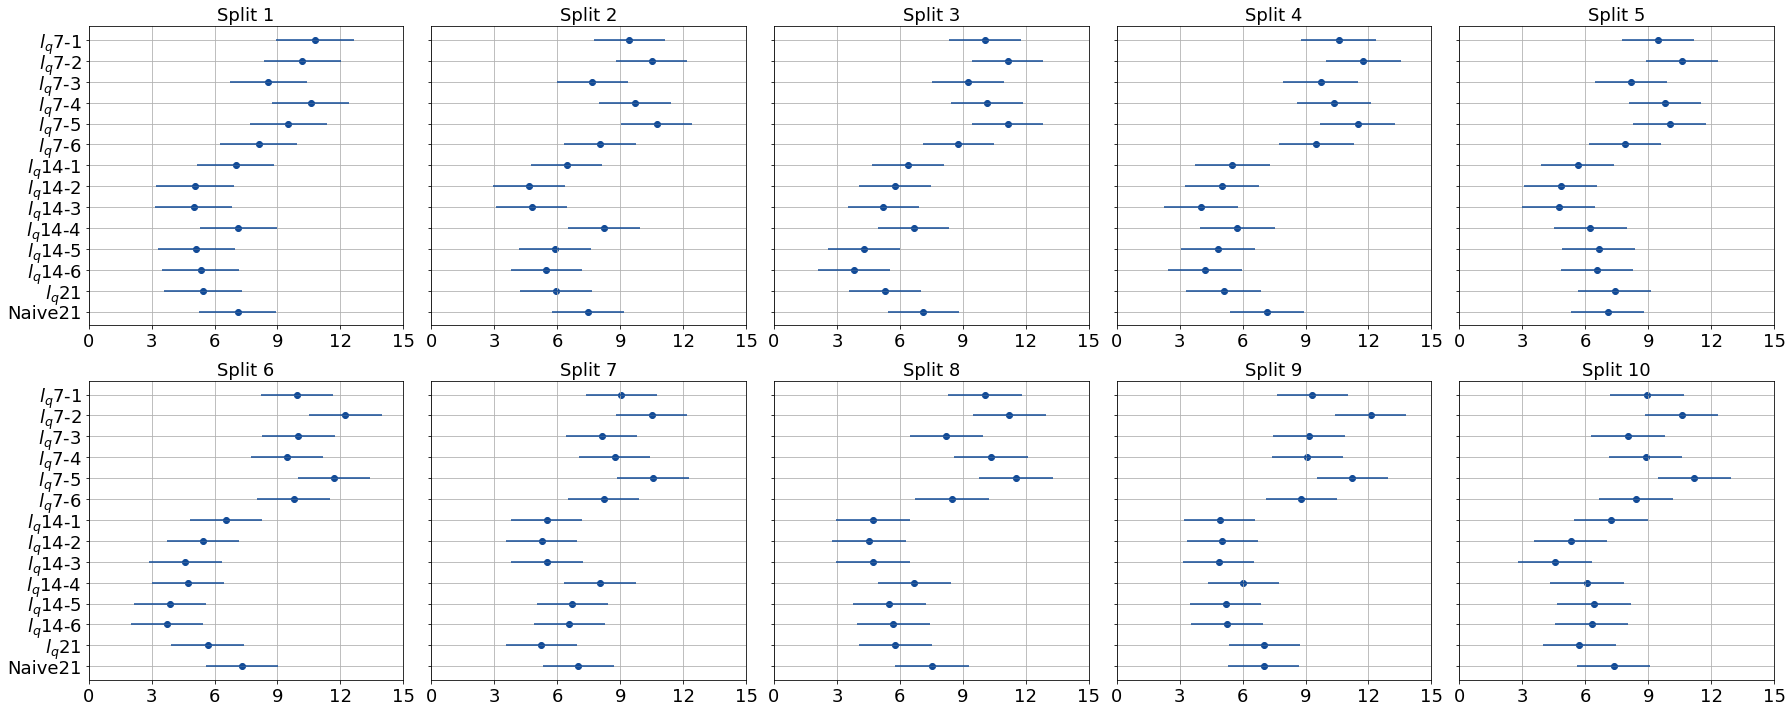

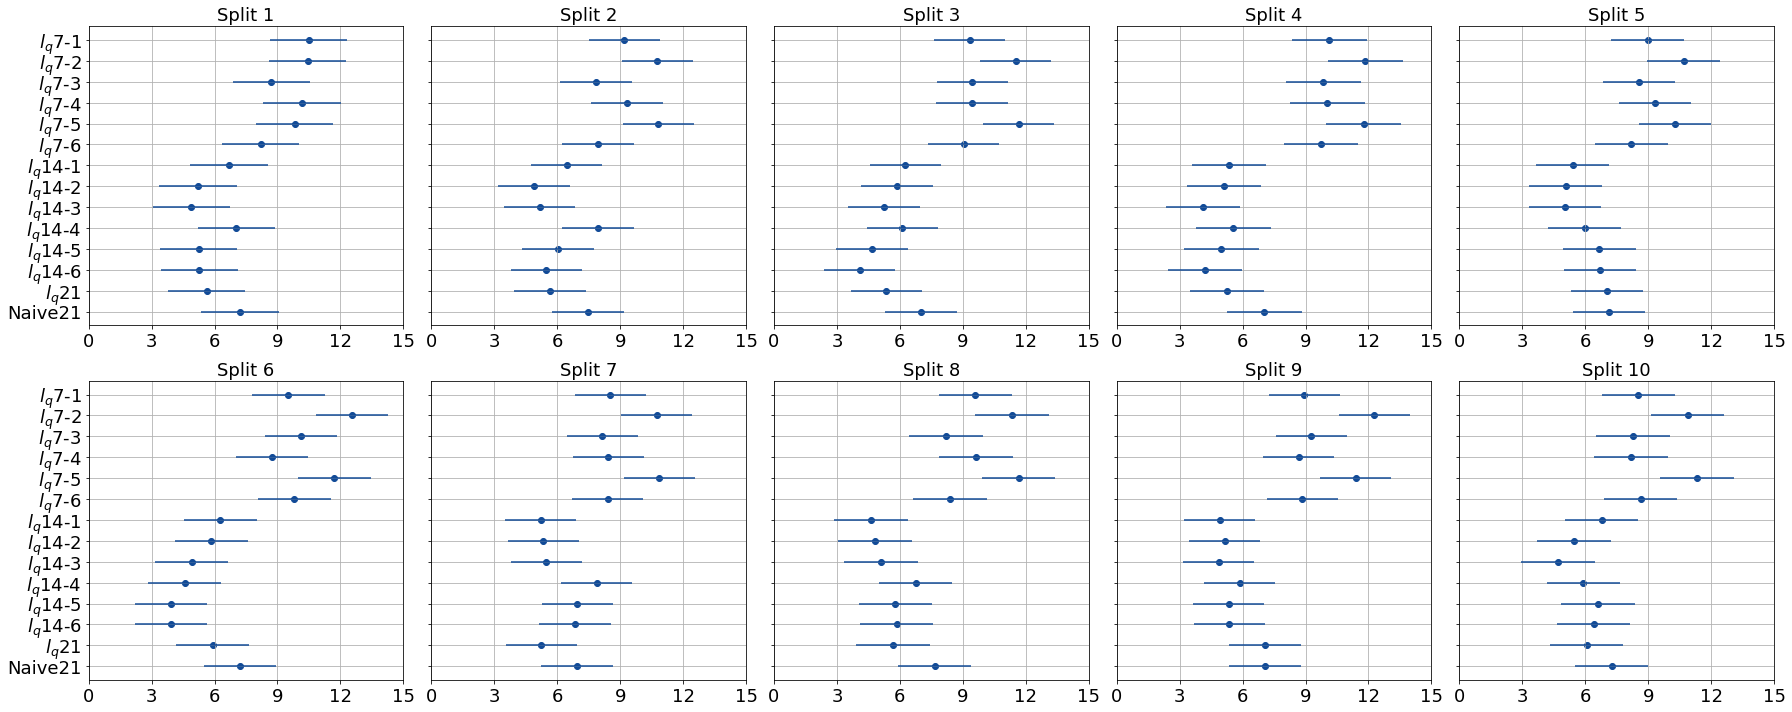

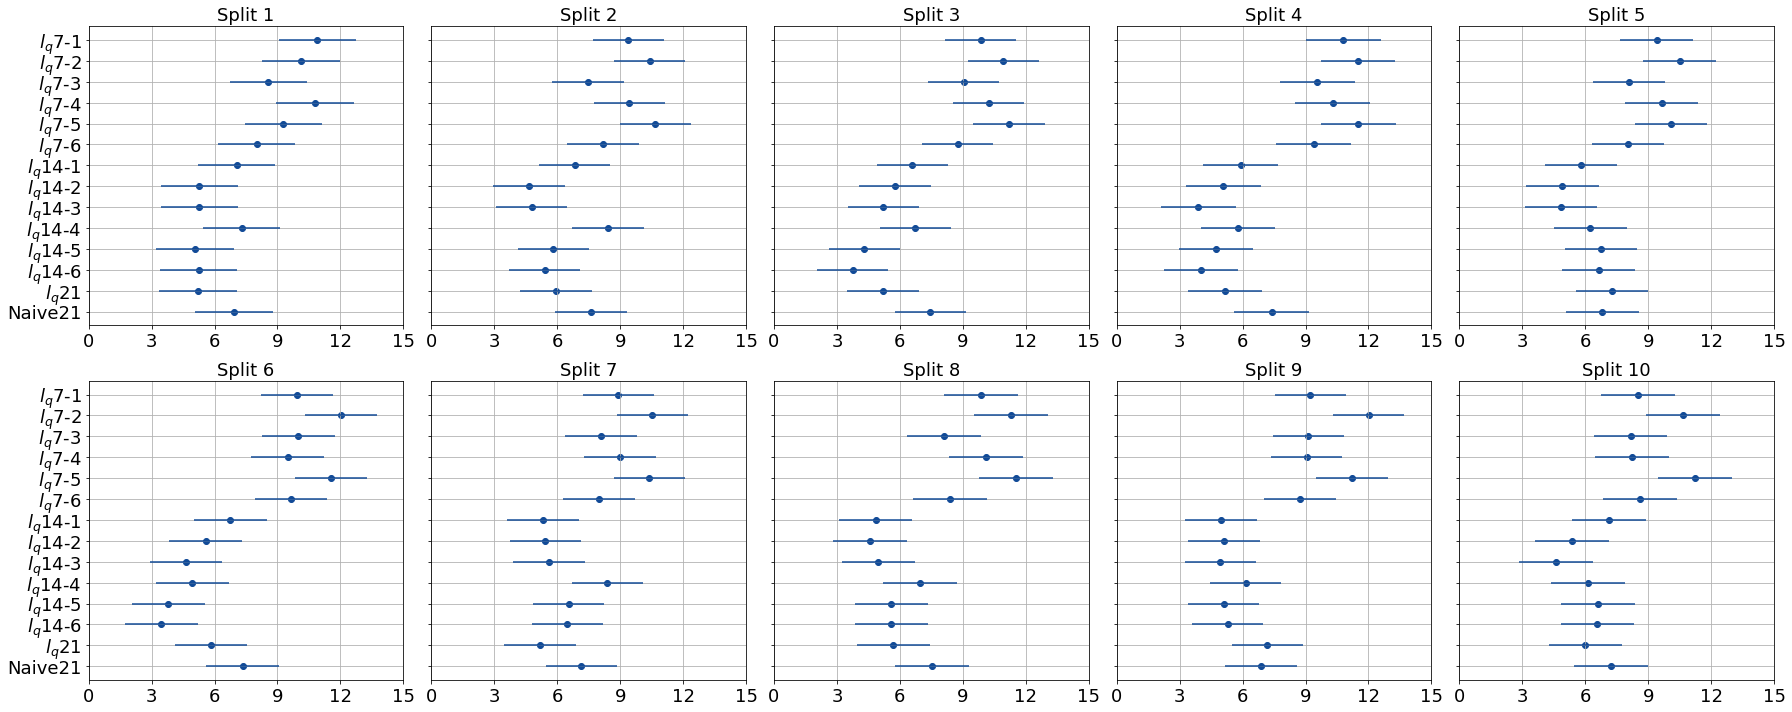

In [7]:
# MAPE
f, axes = plt.subplots(2, 5, figsize=(25, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

counter = 0
for rs in split_rs:
    
    df = pd.read_excel(current_dir+'/Analysis-lq/MAPE/MAPE-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)

    rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
    for j in range(len(df)):
        rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')

    pvalue = scipy.stats.friedmanchisquare(df['lq7-1_mape'], df['lq7-2_mape'], df['lq7-3_mape'], df['lq7-4_mape'], df['lq7-5_mape'], df['lq7-6_mape'], 
                                           df['lq14-1_mape'], df['lq14-2_mape'], df['lq14-3_mape'], df['lq14-4_mape'], df['lq14-5_mape'], df['lq14-6_mape'], 
                                           df['lq21_mape'], df['Naive21_mape']).pvalue
    
    if pvalue <= 0.05:
        print(pvalue, rs, 'MAPE Passed')
    else:
        print(pvalue, rs, '===MAPE Failed===')
    
    CD = nemenyi_value(n_models, len(rank), q_alpha)
    rank_mean = list(rank.mean())
    interval_min = [x for x in rank_mean-CD/2]
    interval_max = [x for x in rank_mean+CD/2]

    rank.columns = ['$l_q$7-1', '$l_q$7-2', '$l_q$7-3', '$l_q$7-4', '$l_q$7-5', '$l_q$7-6', '$l_q$14-1', '$l_q$14-2', '$l_q$14-3', '$l_q$14-4', '$l_q$14-5', '$l_q$14-6', '$l_q$21', 'Naive21']
    axes_list[counter].scatter(rank_mean, rank.columns, color='#114A97')
    axes_list[counter].hlines(rank.columns, interval_min, interval_max, color='#114A97')
    axes_list[counter].set_xlim(0, 15)
    axes_list[counter].set_xticks(np.linspace(0,15,6))
    axes_list[counter].set_ylim(axes_list[counter].get_ylim()[::-1])
    axes_list[counter].tick_params(axis='both', which='major', labelsize=18)
    axes_list[counter].set_title('Split '+str(counter+1), size=18)
    axes_list[counter].grid()
    if (counter != 0) and (counter != 5):
        axes_list[counter].set_yticklabels('')
    counter += 1

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_12.png')

# MAE
f, axes = plt.subplots(2, 5, figsize=(25, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

counter = 0
for rs in split_rs:
    
    df = pd.read_excel(current_dir+'/Analysis-lq/MAE/MAE-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)

    rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
    for j in range(len(df)):
        rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')

    pvalue = scipy.stats.friedmanchisquare(df['lq7-1_mae'], df['lq7-2_mae'], df['lq7-3_mae'], df['lq7-4_mae'], df['lq7-5_mae'], df['lq7-6_mae'], 
                                           df['lq14-1_mae'], df['lq14-2_mae'], df['lq14-3_mae'], df['lq14-4_mae'], df['lq14-5_mae'], df['lq14-6_mae'], 
                                           df['lq21_mae'], df['Naive21_mae']).pvalue
    
    if pvalue <= 0.05:
        print(pvalue, rs, 'MAE Passed')
    else:
        print(pvalue, rs, '===MAE Failed===')
    
    CD = nemenyi_value(n_models, len(rank), q_alpha)
    rank_mean = list(rank.mean())
    interval_min = [x for x in rank_mean-CD/2]
    interval_max = [x for x in rank_mean+CD/2]

    rank.columns = ['$l_q$7-1', '$l_q$7-2', '$l_q$7-3', '$l_q$7-4', '$l_q$7-5', '$l_q$7-6', '$l_q$14-1', '$l_q$14-2', '$l_q$14-3', '$l_q$14-4', '$l_q$14-5', '$l_q$14-6', '$l_q$21', 'Naive21']
    axes_list[counter].scatter(rank_mean, rank.columns, color='#114A97')
    axes_list[counter].hlines(rank.columns, interval_min, interval_max, color='#114A97')
    axes_list[counter].set_xlim(0, 15)
    axes_list[counter].set_xticks(np.linspace(0,15,6))
    axes_list[counter].set_ylim(axes_list[counter].get_ylim()[::-1])
    axes_list[counter].tick_params(axis='both', which='major', labelsize=18)
    axes_list[counter].set_title('Split '+str(counter+1), size=18)
    axes_list[counter].grid()
    if (counter != 0) and (counter != 5):
        axes_list[counter].set_yticklabels('')
    counter += 1

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_13.png')

# MR
f, axes = plt.subplots(2, 5, figsize=(25, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

counter = 0
for rs in split_rs:
    
    df = pd.read_excel(current_dir+'/Analysis-lq/MR/MR-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)

    rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
    for j in range(len(df)):
        rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')

    pvalue = scipy.stats.friedmanchisquare(df['lq7-1_mr'], df['lq7-2_mr'], df['lq7-3_mr'], df['lq7-4_mr'], df['lq7-5_mr'], df['lq7-6_mr'], 
                                           df['lq14-1_mr'], df['lq14-2_mr'], df['lq14-3_mr'], df['lq14-4_mr'], df['lq14-5_mr'], df['lq14-6_mr'], 
                                           df['lq21_mr'], df['Naive21_mr']).pvalue
    
    if pvalue <= 0.05:
        print(pvalue, rs, 'MR Passed')
    else:
        print(pvalue, rs, '===MR Failed===')
    
    CD = nemenyi_value(n_models, len(rank), q_alpha)
    rank_mean = list(rank.mean())
    interval_min = [x for x in rank_mean-CD/2]
    interval_max = [x for x in rank_mean+CD/2]

    rank.columns = ['$l_q$7-1', '$l_q$7-2', '$l_q$7-3', '$l_q$7-4', '$l_q$7-5', '$l_q$7-6', '$l_q$14-1', '$l_q$14-2', '$l_q$14-3', '$l_q$14-4', '$l_q$14-5', '$l_q$14-6', '$l_q$21', 'Naive21']
    axes_list[counter].scatter(rank_mean, rank.columns, color='#114A97')
    axes_list[counter].hlines(rank.columns, interval_min, interval_max, color='#114A97')
    axes_list[counter].set_xlim(0, 15)
    axes_list[counter].set_xticks(np.linspace(0,15,6))
    axes_list[counter].set_ylim(axes_list[counter].get_ylim()[::-1])
    axes_list[counter].tick_params(axis='both', which='major', labelsize=18)
    axes_list[counter].set_title('Split '+str(counter+1), size=18)
    axes_list[counter].grid()
    if (counter != 0) and (counter != 5):
        axes_list[counter].set_yticklabels('')
    counter += 1

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_14.png')

#### Supp. figure 15

Global tests. Friedman test results are printed out as numbers (p-values) and texts (passed or failed). Nemenyi test results are printed out as figures.

MAPE 5.801886580951154e-252 Passed
MAE 9.749371545110857e-245 Passed
MR 1.1293892187648354e-239 Passed


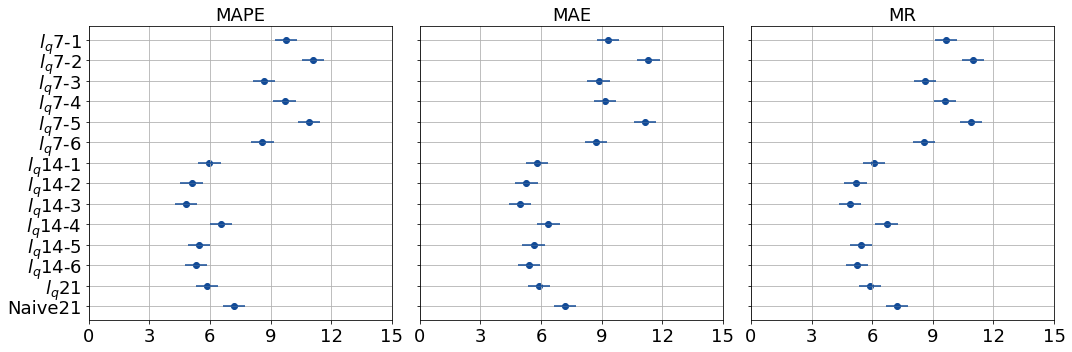

In [8]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]
axes_list = [ax1, ax2, ax3]

# MAPE
df = pd.read_excel(current_dir+'/Analysis-lq/MAPE/MAPE-'+str(split_rs[0])+'.xlsx', header = 0, sheet_name = 0)
for rs in split_rs[1:]:
    df_new = pd.read_excel(current_dir+'/Analysis-lq/MAPE/MAPE-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = pd.concat((df, df_new))
df = df.reset_index(drop=True)

rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
for j in range(len(df)):
    rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')

pvalue = scipy.stats.friedmanchisquare(df['lq7-1_mape'], df['lq7-2_mape'], df['lq7-3_mape'], df['lq7-4_mape'], df['lq7-5_mape'], df['lq7-6_mape'], 
                                       df['lq14-1_mape'], df['lq14-2_mape'], df['lq14-3_mape'], df['lq14-4_mape'], df['lq14-5_mape'], df['lq14-6_mape'], 
                                       df['lq21_mape'], df['Naive21_mape']).pvalue

if pvalue <= 0.05:
    print('MAPE', pvalue, 'Passed')
else:
    print('MAPE', pvalue, 'Failed')

CD = nemenyi_value(n_models, len(rank), q_alpha)
rank_mean = list(rank.mean())
interval_min = [x for x in rank_mean-CD/2]
interval_max = [x for x in rank_mean+CD/2]

rank.columns = ['$l_q$7-1', '$l_q$7-2', '$l_q$7-3', '$l_q$7-4', '$l_q$7-5', '$l_q$7-6', '$l_q$14-1', '$l_q$14-2', '$l_q$14-3', '$l_q$14-4', '$l_q$14-5', '$l_q$14-6', '$l_q$21', 'Naive21']  
ax1.scatter(rank_mean, rank.columns, color='#114A97')
ax1.hlines(rank.columns, interval_min, interval_max, color='#114A97')
ax1.set_xlim(1,14)
ax1.set_xticks(np.linspace(0,15,6))
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.grid()

# MAE
df = pd.read_excel(current_dir+'/Analysis-lq/MAE/MAE-'+str(split_rs[0])+'.xlsx', header = 0, sheet_name = 0)
for rs in split_rs[1:]:
    df_new = pd.read_excel(current_dir+'/Analysis-lq/MAE/MAE-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = pd.concat((df, df_new))
df = df.reset_index(drop=True)

rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
for j in range(len(df)):
    rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')

pvalue = scipy.stats.friedmanchisquare(df['lq7-1_mae'], df['lq7-2_mae'], df['lq7-3_mae'], df['lq7-4_mae'], df['lq7-5_mae'], df['lq7-6_mae'], 
                                       df['lq14-1_mae'], df['lq14-2_mae'], df['lq14-3_mae'], df['lq14-4_mae'], df['lq14-5_mae'], df['lq14-6_mae'], 
                                       df['lq21_mae'], df['Naive21_mae']).pvalue

if pvalue <= 0.05:
    print('MAE', pvalue, 'Passed')
else:
    print('MAE', pvalue, 'Failed')

CD = nemenyi_value(n_models, len(rank), q_alpha)
rank_mean = list(rank.mean())
interval_min = [x for x in rank_mean-CD/2]
interval_max = [x for x in rank_mean+CD/2]

rank.columns = ['$l_q$7-1', '$l_q$7-2', '$l_q$7-3', '$l_q$7-4', '$l_q$7-5', '$l_q$7-6', '$l_q$14-1', '$l_q$14-2', '$l_q$14-3', '$l_q$14-4', '$l_q$14-5', '$l_q$14-6', '$l_q$21', 'Naive21']
ax2.scatter(rank_mean, rank.columns, color='#114A97')
ax2.hlines(rank.columns, interval_min, interval_max, color='#114A97')
ax2.set_xlim(1,14)
ax2.set_xticks(np.linspace(0,15,6))
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.grid()

# MR
df = pd.read_excel(current_dir+'/Analysis-lq/MR/MR-'+str(split_rs[0])+'.xlsx', header = 0, sheet_name = 0)
for rs in split_rs[1:]:
    df_new = pd.read_excel(current_dir+'/Analysis-lq/MR/MR-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = pd.concat((df, df_new))
df = df.reset_index(drop=True)

rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
for j in range(len(df)):
    rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')
    
pvalue = scipy.stats.friedmanchisquare(df['lq7-1_mr'], df['lq7-2_mr'], df['lq7-3_mr'], df['lq7-4_mr'], df['lq7-5_mr'], df['lq7-6_mr'], 
                                       df['lq14-1_mr'], df['lq14-2_mr'], df['lq14-3_mr'], df['lq14-4_mr'], df['lq14-5_mr'], df['lq14-6_mr'], 
                                       df['lq21_mr'], df['Naive21_mr']).pvalue

if pvalue <= 0.05:
    print('MR', pvalue, 'Passed')
else:
    print('MR', pvalue, 'Failed')

CD = nemenyi_value(n_models, len(rank), q_alpha)
rank_mean = list(rank.mean())
interval_min = [x for x in rank_mean-CD/2]
interval_max = [x for x in rank_mean+CD/2]

rank.columns = ['$l_q$7-1', '$l_q$7-2', '$l_q$7-3', '$l_q$7-4', '$l_q$7-5', '$l_q$7-6', '$l_q$14-1', '$l_q$14-2', '$l_q$14-3', '$l_q$14-4', '$l_q$14-5', '$l_q$14-6', '$l_q$21', 'Naive21']
ax3.scatter(rank_mean, rank.columns, color='#114A97')
ax3.hlines(rank.columns, interval_min, interval_max, color='#114A97')
ax3.set_xlim(1,14)
ax3.set_xticks(np.linspace(0,15,6))
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.tick_params(axis='both', which='major', labelsize=18)
ax3.grid()

ax1.set_title('MAPE', size=18)
ax2.set_title('MAE', size=18)
ax3.set_title('MR', size=18)
ax2.set_yticklabels('')
ax3.set_yticklabels('')

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_15.png')

### Result plots of the sensitivity analysis (Section 3.4)

#### Figure 12

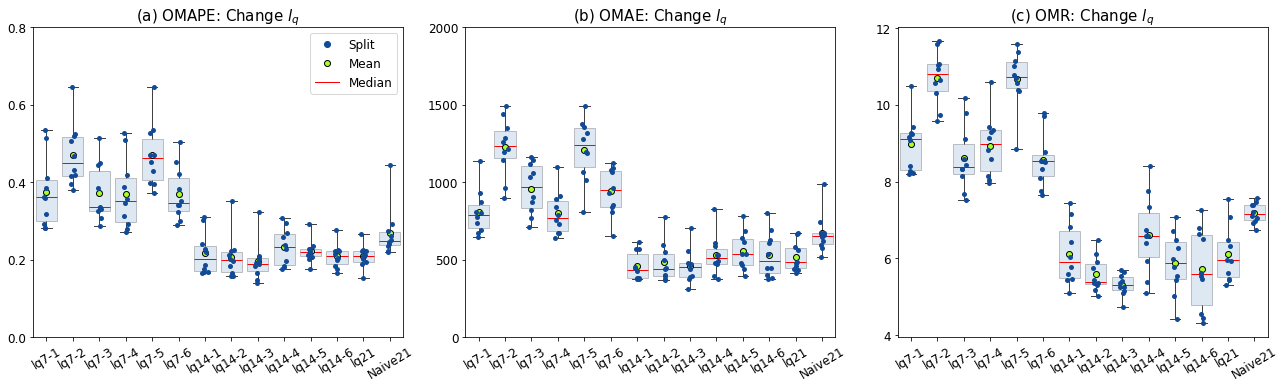

In [9]:
df = pd.read_excel(current_dir+'/Analysis-lq/Metrics.xlsx', header = 0, sheet_name = 0)
df1 = df[['lq7-1_omape', 'lq7-2_omape', 'lq7-3_omape', 'lq7-4_omape', 'lq7-5_omape', 'lq7-6_omape', 'lq14-1_omape', 'lq14-2_omape', 'lq14-3_omape', 'lq14-4_omape', 'lq14-5_omape', 'lq14-6_omape', 'lq21_omape', 'Naive21_omape']]
df1.columns = ['lq7-1', 'lq7-2', 'lq7-3', 'lq7-4', 'lq7-5', 'lq7-6', 'lq14-1', 'lq14-2', 'lq14-3', 'lq14-4', 'lq14-5', 'lq14-6', 'lq21', 'Naive21']
df2 = df[['lq7-1_omae', 'lq7-2_omae', 'lq7-3_omae', 'lq7-4_omae', 'lq7-5_omae', 'lq7-6_omae', 'lq14-1_omae', 'lq14-2_omae', 'lq14-3_omae', 'lq14-4_omae', 'lq14-5_omae', 'lq14-6_omae', 'lq21_omae', 'Naive21_omae']]
df2.columns = ['lq7-1', 'lq7-2', 'lq7-3', 'lq7-4', 'lq7-5', 'lq7-6', 'lq14-1', 'lq14-2', 'lq14-3', 'lq14-4', 'lq14-5', 'lq14-6', 'lq21', 'Naive21']
df3 = df[['lq7-1_omr', 'lq7-2_omr', 'lq7-3_omr', 'lq7-4_omr', 'lq7-5_omr', 'lq7-6_omr', 'lq14-1_omr', 'lq14-2_omr', 'lq14-3_omr', 'lq14-4_omr', 'lq14-5_omr', 'lq14-6_omr', 'lq21_omr', 'Naive21_omr']]
df3.columns = ['lq7-1', 'lq7-2', 'lq7-3', 'lq7-4', 'lq7-5', 'lq7-6', 'lq14-1', 'lq14-2', 'lq14-3', 'lq14-4', 'lq14-5', 'lq14-6', 'lq21', 'Naive21']

f, axes = plt.subplots(1, 3, figsize=(18, 5.5))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]
axes_list = [ax1, ax2, ax3]
ax1 = sns.boxplot(data=df1, ax=ax1, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax2 = sns.boxplot(data=df2, ax=ax2, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax3 = sns.boxplot(data=df3, ax=ax3, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
sns.stripplot(data=df1, ax=ax1, color='#114A97')
sns.stripplot(data=df2, ax=ax2, color='#114A97')
sns.stripplot(data=df3, ax=ax3, color='#114A97')
ax1.set_title('(a) OMAPE: Change $l_q$', size=15)
ax2.set_title('(b) OMAE: Change $l_q$', size=15) 
ax3.set_title('(c) OMR: Change $l_q$', size=15)
ax1.set_yticks(np.linspace(0, 0.8, 5))
ax2.set_yticks(np.linspace(0, 2000, 5))
ax3.set_yticks(np.linspace(4, 12, 5))
for ax in axes_list:
    ax.tick_params(axis='x', rotation=31)
    ax.tick_params(axis='both', which='major', labelsize=12)

legend_elements = [Line2D([], [], color='#114A97', marker='o', linestyle='', label='Split'),
                   Line2D([], [], color='#A9FD2B', marker='o', markeredgecolor='black', linestyle='', label='Mean'),
                   Line2D([0], [0], color='red', lw=1, label='Median')]
ax1.legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/Figure_12.png')

#### Supp. figures 5 to 7

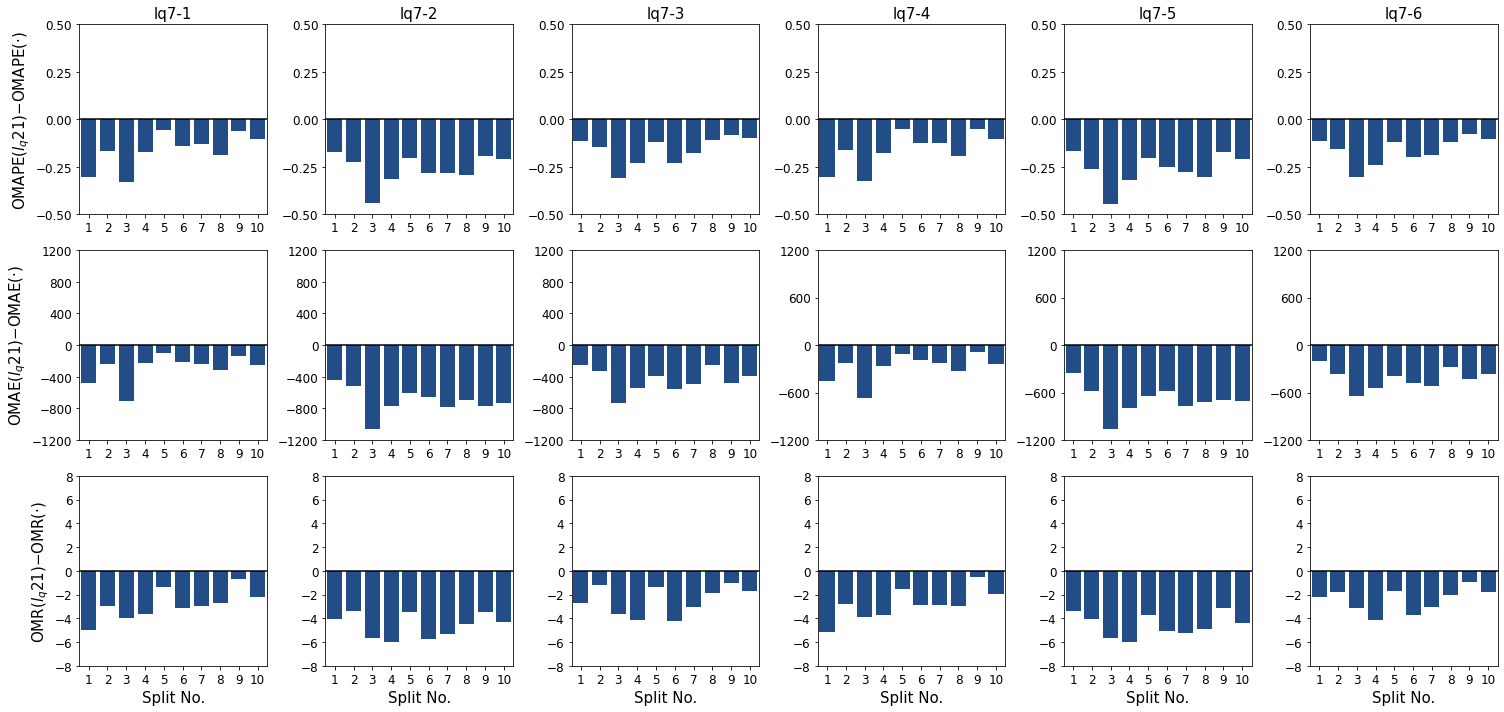

In [10]:
df = pd.read_excel(current_dir+'/Analysis-lq/Metrics.xlsx', header = 0, sheet_name = 0)

df1 = df[['lq7-1_omape', 'lq7-2_omape', 'lq7-3_omape', 'lq7-4_omape', 'lq7-5_omape', 'lq7-6_omape', 'lq21_omape']]
df1['lq7-1'] = df1['lq21_omape'] - df1['lq7-1_omape']
df1['lq7-2'] = df1['lq21_omape'] - df1['lq7-2_omape']
df1['lq7-3'] = df1['lq21_omape'] - df1['lq7-3_omape']
df1['lq7-4'] = df1['lq21_omape'] - df1['lq7-4_omape']
df1['lq7-5'] = df1['lq21_omape'] - df1['lq7-5_omape']
df1['lq7-6'] = df1['lq21_omape'] - df1['lq7-6_omape']
df1 = df1[['lq7-1', 'lq7-2', 'lq7-3', 'lq7-4', 'lq7-5', 'lq7-6']]

df2 = df[['lq7-1_omae', 'lq7-2_omae', 'lq7-3_omae', 'lq7-4_omae', 'lq7-5_omae', 'lq7-6_omae', 'lq21_omae']]
df2['lq7-1'] = df2['lq21_omae'] - df2['lq7-1_omae']
df2['lq7-2'] = df2['lq21_omae'] - df2['lq7-2_omae']
df2['lq7-3'] = df2['lq21_omae'] - df2['lq7-3_omae']
df2['lq7-4'] = df2['lq21_omae'] - df2['lq7-4_omae']
df2['lq7-5'] = df2['lq21_omae'] - df2['lq7-5_omae']
df2['lq7-6'] = df2['lq21_omae'] - df2['lq7-6_omae']
df2 = df2[['lq7-1', 'lq7-2', 'lq7-3', 'lq7-4', 'lq7-5', 'lq7-6']]

df3 = df[['lq7-1_omr', 'lq7-2_omr', 'lq7-3_omr', 'lq7-4_omr', 'lq7-5_omr', 'lq7-6_omr', 'lq21_omr']]
df3['lq7-1'] = df3['lq21_omr'] - df3['lq7-1_omr']
df3['lq7-2'] = df3['lq21_omr'] - df3['lq7-2_omr']
df3['lq7-3'] = df3['lq21_omr'] - df3['lq7-3_omr']
df3['lq7-4'] = df3['lq21_omr'] - df3['lq7-4_omr']
df3['lq7-5'] = df3['lq21_omr'] - df3['lq7-5_omr']
df3['lq7-6'] = df3['lq21_omr'] - df3['lq7-6_omr']
df3 = df3[['lq7-1', 'lq7-2', 'lq7-3', 'lq7-4', 'lq7-5', 'lq7-6']]

f, axes = plt.subplots(3, 6, figsize=(21, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4], axes[0,5]
ax7, ax8, ax9, ax10, ax11, ax12 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4], axes[1,5]
ax13, ax14, ax15, ax16, ax17, ax18 = axes[2,0], axes[2,1], axes[2,2], axes[2,3], axes[2,4], axes[2,5]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18]

ax1 = sns.barplot(x=df1.index+1, y=df1['lq7-1'].T, ax=ax1, color='#114A97')
ax2 = sns.barplot(x=df1.index+1, y=df1['lq7-2'].T, ax=ax2, color='#114A97')
ax3 = sns.barplot(x=df1.index+1, y=df1['lq7-3'].T, ax=ax3, color='#114A97')
ax4 = sns.barplot(x=df1.index+1, y=df1['lq7-4'].T, ax=ax4, color='#114A97')
ax5 = sns.barplot(x=df1.index+1, y=df1['lq7-5'].T, ax=ax5, color='#114A97')
ax6 = sns.barplot(x=df1.index+1, y=df1['lq7-6'].T, ax=ax6, color='#114A97')
ax7 = sns.barplot(x=df2.index+1, y=df2['lq7-1'].T, ax=ax7, color='#114A97')
ax8 = sns.barplot(x=df2.index+1, y=df2['lq7-2'].T, ax=ax8, color='#114A97')
ax9 = sns.barplot(x=df2.index+1, y=df2['lq7-3'].T, ax=ax9, color='#114A97')
ax10 = sns.barplot(x=df2.index+1, y=df2['lq7-4'].T, ax=ax10, color='#114A97')
ax11 = sns.barplot(x=df2.index+1, y=df2['lq7-5'].T, ax=ax11, color='#114A97')
ax12 = sns.barplot(x=df2.index+1, y=df2['lq7-6'].T, ax=ax12, color='#114A97')
ax13 = sns.barplot(x=df3.index+1, y=df3['lq7-1'].T, ax=ax13, color='#114A97')
ax14 = sns.barplot(x=df3.index+1, y=df3['lq7-2'].T, ax=ax14, color='#114A97')
ax15 = sns.barplot(x=df3.index+1, y=df3['lq7-3'].T, ax=ax15, color='#114A97')
ax16 = sns.barplot(x=df3.index+1, y=df3['lq7-4'].T, ax=ax16, color='#114A97')
ax17 = sns.barplot(x=df3.index+1, y=df3['lq7-5'].T, ax=ax17, color='#114A97')
ax18 = sns.barplot(x=df3.index+1, y=df3['lq7-6'].T, ax=ax18, color='#114A97')
for ax in axes_list:
    ax.hlines(0, -0.5, 9.5, color='black')
    ax.set_xlim(-0.5, 9.5)

for ax in axes_list:
    ax.set_xlabel('')
    ax.set_ylabel('')
ax1.set_ylabel('OMAPE($l_q$21)$-$OMAPE(·)', size=15)
ax7.set_ylabel('OMAE($l_q$21)$-$OMAE(·)', size=15)
ax13.set_ylabel('OMR($l_q$21)$-$OMR(·)', size=15)
ax13.set_xlabel('Split No.', size=15)
ax14.set_xlabel('Split No.', size=15)
ax15.set_xlabel('Split No.', size=15)
ax16.set_xlabel('Split No.', size=15)
ax17.set_xlabel('Split No.', size=15)
ax18.set_xlabel('Split No.', size=15)
ax1.set_title('lq7-1', size=15)
ax2.set_title('lq7-2', size=15)
ax3.set_title('lq7-3', size=15)
ax4.set_title('lq7-4', size=15)
ax5.set_title('lq7-5', size=15)
ax6.set_title('lq7-6', size=15)

ax1.set_yticks(np.linspace(-0.5, 0.5, 5))
ax2.set_yticks(np.linspace(-0.5, 0.5, 5))
ax3.set_yticks(np.linspace(-0.5, 0.5, 5))
ax4.set_yticks(np.linspace(-0.5, 0.5,  5))
ax5.set_yticks(np.linspace(-0.5, 0.5, 5))
ax6.set_yticks(np.linspace(-0.5, 0.5, 5))
ax7.set_yticks(np.linspace(-1200, 1200, 7))
ax8.set_yticks(np.linspace(-1200, 1200, 7))
ax9.set_yticks(np.linspace(-1200, 1200, 7))
ax10.set_yticks(np.linspace(-1200, 1200, 5))
ax11.set_yticks(np.linspace(-1200, 1200, 5))
ax12.set_yticks(np.linspace(-1200, 1200, 5))
ax13.set_yticks(np.linspace(-8, 8, 9))
ax14.set_yticks(np.linspace(-8, 8, 9))
ax15.set_yticks(np.linspace(-8, 8, 9))
ax16.set_yticks(np.linspace(-8, 8, 9))
ax17.set_yticks(np.linspace(-8, 8, 9))
ax18.set_yticks(np.linspace(-8, 8, 9))

for ax in axes_list:
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_5.png')

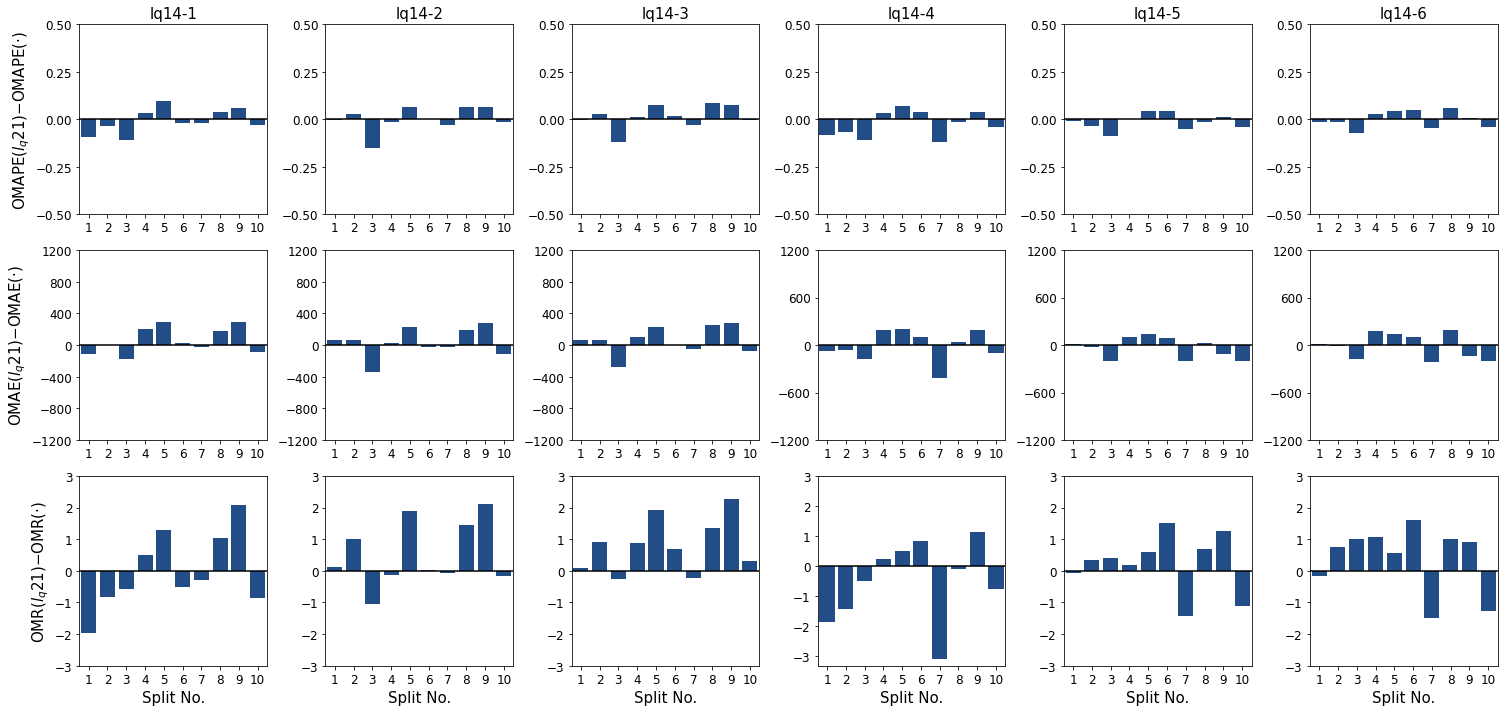

In [11]:
df = pd.read_excel(current_dir+'/Analysis-lq/Metrics.xlsx', header = 0, sheet_name = 0)

df1 = df[['lq14-1_omape', 'lq14-2_omape', 'lq14-3_omape', 'lq14-4_omape', 'lq14-5_omape', 'lq14-6_omape', 'lq21_omape']]
df1['lq14-1'] = df1['lq21_omape'] - df1['lq14-1_omape']
df1['lq14-2'] = df1['lq21_omape'] - df1['lq14-2_omape']
df1['lq14-3'] = df1['lq21_omape'] - df1['lq14-3_omape']
df1['lq14-4'] = df1['lq21_omape'] - df1['lq14-4_omape']
df1['lq14-5'] = df1['lq21_omape'] - df1['lq14-5_omape']
df1['lq14-6'] = df1['lq21_omape'] - df1['lq14-6_omape']
df1 = df1[['lq14-1', 'lq14-2', 'lq14-3', 'lq14-4', 'lq14-5', 'lq14-6']]

df2 = df[['lq14-1_omae', 'lq14-2_omae', 'lq14-3_omae', 'lq14-4_omae', 'lq14-5_omae', 'lq14-6_omae', 'lq21_omae']]
df2['lq14-1'] = df2['lq21_omae'] - df2['lq14-1_omae']
df2['lq14-2'] = df2['lq21_omae'] - df2['lq14-2_omae']
df2['lq14-3'] = df2['lq21_omae'] - df2['lq14-3_omae']
df2['lq14-4'] = df2['lq21_omae'] - df2['lq14-4_omae']
df2['lq14-5'] = df2['lq21_omae'] - df2['lq14-5_omae']
df2['lq14-6'] = df2['lq21_omae'] - df2['lq14-6_omae']
df2 = df2[['lq14-1', 'lq14-2', 'lq14-3', 'lq14-4', 'lq14-5', 'lq14-6']]

df3 = df[['lq14-1_omr', 'lq14-2_omr', 'lq14-3_omr', 'lq14-4_omr', 'lq14-5_omr', 'lq14-6_omr', 'lq21_omr']]
df3['lq14-1'] = df3['lq21_omr'] - df3['lq14-1_omr']
df3['lq14-2'] = df3['lq21_omr'] - df3['lq14-2_omr']
df3['lq14-3'] = df3['lq21_omr'] - df3['lq14-3_omr']
df3['lq14-4'] = df3['lq21_omr'] - df3['lq14-4_omr']
df3['lq14-5'] = df3['lq21_omr'] - df3['lq14-5_omr']
df3['lq14-6'] = df3['lq21_omr'] - df3['lq14-6_omr']
df3 = df3[['lq14-1', 'lq14-2', 'lq14-3', 'lq14-4', 'lq14-5', 'lq14-6']]

f, axes = plt.subplots(3, 6, figsize=(21, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4], axes[0,5]
ax7, ax8, ax9, ax10, ax11, ax12 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4], axes[1,5]
ax13, ax14, ax15, ax16, ax17, ax18 = axes[2,0], axes[2,1], axes[2,2], axes[2,3], axes[2,4], axes[2,5]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18]

ax1 = sns.barplot(x=df1.index+1, y=df1['lq14-1'].T, ax=ax1, color='#114A97')
ax2 = sns.barplot(x=df1.index+1, y=df1['lq14-2'].T, ax=ax2, color='#114A97')
ax3 = sns.barplot(x=df1.index+1, y=df1['lq14-3'].T, ax=ax3, color='#114A97')
ax4 = sns.barplot(x=df1.index+1, y=df1['lq14-4'].T, ax=ax4, color='#114A97')
ax5 = sns.barplot(x=df1.index+1, y=df1['lq14-5'].T, ax=ax5, color='#114A97')
ax6 = sns.barplot(x=df1.index+1, y=df1['lq14-6'].T, ax=ax6, color='#114A97')
ax7 = sns.barplot(x=df2.index+1, y=df2['lq14-1'].T, ax=ax7, color='#114A97')
ax8 = sns.barplot(x=df2.index+1, y=df2['lq14-2'].T, ax=ax8, color='#114A97')
ax9 = sns.barplot(x=df2.index+1, y=df2['lq14-3'].T, ax=ax9, color='#114A97')
ax10 = sns.barplot(x=df2.index+1, y=df2['lq14-4'].T, ax=ax10, color='#114A97')
ax11 = sns.barplot(x=df2.index+1, y=df2['lq14-5'].T, ax=ax11, color='#114A97')
ax12 = sns.barplot(x=df2.index+1, y=df2['lq14-6'].T, ax=ax12, color='#114A97')
ax13 = sns.barplot(x=df3.index+1, y=df3['lq14-1'].T, ax=ax13, color='#114A97')
ax14 = sns.barplot(x=df3.index+1, y=df3['lq14-2'].T, ax=ax14, color='#114A97')
ax15 = sns.barplot(x=df3.index+1, y=df3['lq14-3'].T, ax=ax15, color='#114A97')
ax16 = sns.barplot(x=df3.index+1, y=df3['lq14-4'].T, ax=ax16, color='#114A97')
ax17 = sns.barplot(x=df3.index+1, y=df3['lq14-5'].T, ax=ax17, color='#114A97')
ax18 = sns.barplot(x=df3.index+1, y=df3['lq14-6'].T, ax=ax18, color='#114A97')
for ax in axes_list:
    ax.hlines(0, -0.5, 9.5, color='black')
    ax.set_xlim(-0.5, 9.5)

for ax in axes_list:
    ax.set_xlabel('')
    ax.set_ylabel('')
ax1.set_ylabel('OMAPE($l_q$21)$-$OMAPE(·)', size=15)
ax7.set_ylabel('OMAE($l_q$21)$-$OMAE(·)', size=15)
ax13.set_ylabel('OMR($l_q$21)$-$OMR(·)', size=15)
ax13.set_xlabel('Split No.', size=15)
ax14.set_xlabel('Split No.', size=15)
ax15.set_xlabel('Split No.', size=15)
ax16.set_xlabel('Split No.', size=15)
ax17.set_xlabel('Split No.', size=15)
ax18.set_xlabel('Split No.', size=15)
ax1.set_title('lq14-1', size=15)
ax2.set_title('lq14-2', size=15)
ax3.set_title('lq14-3', size=15)
ax4.set_title('lq14-4', size=15)
ax5.set_title('lq14-5', size=15)
ax6.set_title('lq14-6', size=15)

ax1.set_yticks(np.linspace(-0.5, 0.5, 5))
ax2.set_yticks(np.linspace(-0.5, 0.5, 5))
ax3.set_yticks(np.linspace(-0.5, 0.5, 5))
ax4.set_yticks(np.linspace(-0.5, 0.5,  5))
ax5.set_yticks(np.linspace(-0.5, 0.5, 5))
ax6.set_yticks(np.linspace(-0.5, 0.5, 5))
ax7.set_yticks(np.linspace(-1200, 1200, 7))
ax8.set_yticks(np.linspace(-1200, 1200, 7))
ax9.set_yticks(np.linspace(-1200, 1200, 7))
ax10.set_yticks(np.linspace(-1200, 1200, 5))
ax11.set_yticks(np.linspace(-1200, 1200, 5))
ax12.set_yticks(np.linspace(-1200, 1200, 5))
ax13.set_yticks(np.linspace(-3, 3, 7))
ax14.set_yticks(np.linspace(-3, 3, 7))
ax15.set_yticks(np.linspace(-3, 3, 7))
ax16.set_yticks(np.linspace(-3, 3, 7))
ax17.set_yticks(np.linspace(-3, 3, 7))
ax18.set_yticks(np.linspace(-3, 3, 7))

for ax in axes_list:
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_6.png')

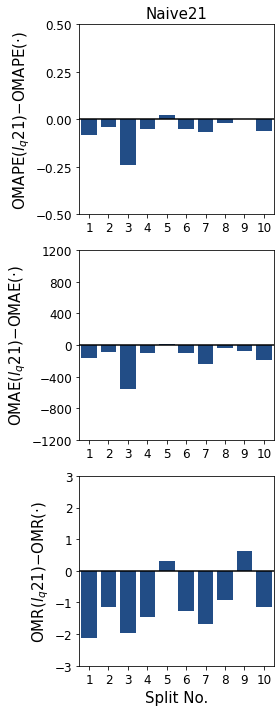

In [12]:
df = pd.read_excel(current_dir+'/Analysis-lq/Metrics.xlsx', header = 0, sheet_name = 0)

df1 = df[['Naive21_omape', 'lq21_omape']]
df1['Naive21'] = df1['lq21_omape'] - df1['Naive21_omape']
df1 = df1[['Naive21']]

df2 = df[['Naive21_omae', 'lq21_omae']]
df2['Naive21'] = df2['lq21_omae'] - df2['Naive21_omae']
df2 = df2[['Naive21']]

df3 = df[['Naive21_omr', 'lq21_omr']]
df3['Naive21'] = df3['lq21_omr'] - df3['Naive21_omr']
df3 = df3[['Naive21']]

f, axes = plt.subplots(3, 1, figsize=(4, 10))
ax1 = axes[0]
ax7 = axes[1]
ax13 = axes[2]
axes_list = [ax1, ax7, ax13]

ax1 = sns.barplot(x=df1.index+1, y=df1['Naive21'].T, ax=ax1, color='#114A97')
ax7 = sns.barplot(x=df2.index+1, y=df2['Naive21'].T, ax=ax7, color='#114A97')
ax13 = sns.barplot(x=df3.index+1, y=df3['Naive21'].T, ax=ax13, color='#114A97')
for ax in axes_list:
    ax.hlines(0, -0.5, 9.5, color='black')
    ax.set_xlim(-0.5, 9.5)

for ax in axes_list:
    ax.set_xlabel('')
    ax.set_ylabel('')
ax1.set_ylabel('OMAPE($l_q$21)$-$OMAPE(·)', size=15)
ax7.set_ylabel('OMAE($l_q$21)$-$OMAE(·)', size=15)
ax13.set_ylabel('OMR($l_q$21)$-$OMR(·)', size=15)
ax13.set_xlabel('Split No.', size=15)
ax1.set_title('Naive21', size=15)

ax1.set_yticks(np.linspace(-0.5, 0.5, 5))
ax7.set_yticks(np.linspace(-1200, 1200, 7))
ax13.set_yticks(np.linspace(-3, 3, 7))

for ax in axes_list:
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_7.png')

#### Supp. figure 8

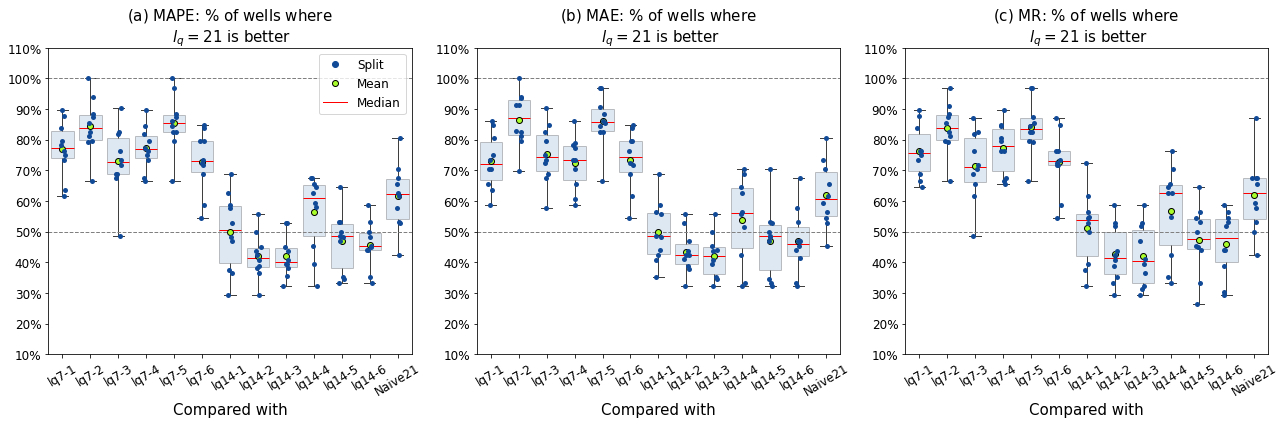

In [13]:
path = current_dir+'/Analysis-lq/Metrics/'
mape_better_lq71, mape_better_lq72, mape_better_lq73, mape_better_lq74, mape_better_lq75, mape_better_lq76, mape_better_lq141, mape_better_lq142, mape_better_lq143, mape_better_lq144, mape_better_lq145, mape_better_lq146, mape_better_naive = [], [], [], [], [], [], [], [], [], [], [], [], []
mae_better_lq71, mae_better_lq72, mae_better_lq73, mae_better_lq74, mae_better_lq75, mae_better_lq76, mae_better_lq141, mae_better_lq142, mae_better_lq143, mae_better_lq144, mae_better_lq145, mae_better_lq146, mae_better_naive = [], [], [], [], [], [], [], [], [], [], [], [], []
mr_better_lq71, mr_better_lq72, mr_better_lq73, mr_better_lq74, mr_better_lq75, mr_better_lq76, mr_better_lq141, mr_better_lq142, mr_better_lq143, mr_better_lq144, mr_better_lq145, mr_better_lq146, mr_better_naive = [], [], [], [], [], [], [], [], [], [], [], [], []
for rs in split_rs:
    df = pd.read_excel(path+'Metrics-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    count_mape_better_lq71, count_mape_better_lq72, count_mape_better_lq73, count_mape_better_lq74, count_mape_better_lq75, count_mape_better_lq76, count_mape_better_lq141, count_mape_better_lq142, count_mape_better_lq143, count_mape_better_lq144, count_mape_better_lq145, count_mape_better_lq146, count_mape_better_naive = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    count_mae_better_lq71, count_mae_better_lq72, count_mae_better_lq73, count_mae_better_lq74, count_mae_better_lq75, count_mae_better_lq76, count_mae_better_lq141, count_mae_better_lq142, count_mae_better_lq143, count_mae_better_lq144, count_mae_better_lq145, count_mae_better_lq146, count_mae_better_naive = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    count_mr_better_lq71, count_mr_better_lq72, count_mr_better_lq73, count_mr_better_lq74, count_mr_better_lq75, count_mr_better_lq76, count_mr_better_lq141, count_mr_better_lq142, count_mr_better_lq143, count_mr_better_lq144, count_mr_better_lq145, count_mr_better_lq146, count_mr_better_naive = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    for j in range(len(df)):
        if df['lq21_mape'][j] - df['lq7-1_mape'][j] < 0:
            count_mape_better_lq71 += 1
        if df['lq21_mape'][j] - df['lq7-2_mape'][j] < 0:
            count_mape_better_lq72 += 1
        if df['lq21_mape'][j] - df['lq7-3_mape'][j] < 0:
            count_mape_better_lq73 += 1
        if df['lq21_mape'][j] - df['lq7-4_mape'][j] < 0:
            count_mape_better_lq74 += 1
        if df['lq21_mape'][j] - df['lq7-5_mape'][j] < 0:
            count_mape_better_lq75 += 1
        if df['lq21_mape'][j] - df['lq7-6_mape'][j] < 0:
            count_mape_better_lq76 += 1
        if df['lq21_mape'][j] - df['lq14-1_mape'][j] < 0:
            count_mape_better_lq141 += 1
        if df['lq21_mape'][j] - df['lq14-2_mape'][j] < 0:
            count_mape_better_lq142 += 1
        if df['lq21_mape'][j] - df['lq14-3_mape'][j] < 0:
            count_mape_better_lq143 += 1
        if df['lq21_mape'][j] - df['lq14-4_mape'][j] < 0:
            count_mape_better_lq144 += 1
        if df['lq21_mape'][j] - df['lq14-5_mape'][j] < 0:
            count_mape_better_lq145 += 1
        if df['lq21_mape'][j] - df['lq14-6_mape'][j] < 0:
            count_mape_better_lq146 += 1
        if df['lq21_mape'][j] - df['Naive21_mape'][j] < 0:
            count_mape_better_naive += 1
        if df['lq21_mae'][j] - df['lq7-1_mae'][j] < 0:
            count_mae_better_lq71 += 1
        if df['lq21_mae'][j] - df['lq7-2_mae'][j] < 0:
            count_mae_better_lq72 += 1
        if df['lq21_mae'][j] - df['lq7-3_mae'][j] < 0:
            count_mae_better_lq73 += 1
        if df['lq21_mae'][j] - df['lq7-4_mae'][j] < 0:
            count_mae_better_lq74 += 1
        if df['lq21_mae'][j] - df['lq7-5_mae'][j] < 0:
            count_mae_better_lq75 += 1
        if df['lq21_mae'][j] - df['lq7-6_mae'][j] < 0:
            count_mae_better_lq76 += 1
        if df['lq21_mae'][j] - df['lq14-1_mae'][j] < 0:
            count_mae_better_lq141 += 1
        if df['lq21_mae'][j] - df['lq14-2_mae'][j] < 0:
            count_mae_better_lq142 += 1
        if df['lq21_mae'][j] - df['lq14-3_mae'][j] < 0:
            count_mae_better_lq143 += 1
        if df['lq21_mae'][j] - df['lq14-4_mae'][j] < 0:
            count_mae_better_lq144 += 1
        if df['lq21_mae'][j] - df['lq14-5_mae'][j] < 0:
            count_mae_better_lq145 += 1
        if df['lq21_mae'][j] - df['lq14-6_mae'][j] < 0:
            count_mae_better_lq146 += 1
        if df['lq21_mae'][j] - df['Naive21_mae'][j] < 0:
            count_mae_better_naive += 1
        if df['lq21_mr'][j] - df['lq7-1_mr'][j] < 0:
            count_mr_better_lq71 += 1
        if df['lq21_mr'][j] - df['lq7-2_mr'][j] < 0:
            count_mr_better_lq72 += 1
        if df['lq21_mr'][j] - df['lq7-3_mr'][j] < 0:
            count_mr_better_lq73 += 1
        if df['lq21_mr'][j] - df['lq7-4_mr'][j] < 0:
            count_mr_better_lq74 += 1
        if df['lq21_mr'][j] - df['lq7-5_mr'][j] < 0:
            count_mr_better_lq75 += 1
        if df['lq21_mr'][j] - df['lq7-6_mr'][j] < 0:
            count_mr_better_lq76 += 1
        if df['lq21_mr'][j] - df['lq14-1_mr'][j] < 0:
            count_mr_better_lq141 += 1
        if df['lq21_mr'][j] - df['lq14-2_mr'][j] < 0:
            count_mr_better_lq142 += 1
        if df['lq21_mr'][j] - df['lq14-3_mr'][j] < 0:
            count_mr_better_lq143 += 1
        if df['lq21_mr'][j] - df['lq14-4_mr'][j] < 0:
            count_mr_better_lq144 += 1
        if df['lq21_mr'][j] - df['lq14-5_mr'][j] < 0:
            count_mr_better_lq145 += 1
        if df['lq21_mr'][j] - df['lq14-6_mr'][j] < 0:
            count_mr_better_lq146 += 1
        if df['lq21_mr'][j] - df['Naive21_mr'][j] < 0:
            count_mr_better_naive += 1
    mape_better_lq71.append(count_mape_better_lq71/len(df))
    mape_better_lq72.append(count_mape_better_lq72/len(df))
    mape_better_lq73.append(count_mape_better_lq73/len(df))
    mape_better_lq74.append(count_mape_better_lq74/len(df))
    mape_better_lq75.append(count_mape_better_lq75/len(df))
    mape_better_lq76.append(count_mape_better_lq76/len(df))
    mape_better_lq141.append(count_mape_better_lq141/len(df))
    mape_better_lq142.append(count_mape_better_lq142/len(df))
    mape_better_lq143.append(count_mape_better_lq143/len(df))
    mape_better_lq144.append(count_mape_better_lq144/len(df))
    mape_better_lq145.append(count_mape_better_lq145/len(df))
    mape_better_lq146.append(count_mape_better_lq146/len(df))
    mape_better_naive.append(count_mape_better_naive/len(df))
    mae_better_lq71.append(count_mae_better_lq71/len(df))
    mae_better_lq72.append(count_mae_better_lq72/len(df))
    mae_better_lq73.append(count_mae_better_lq73/len(df))
    mae_better_lq74.append(count_mae_better_lq74/len(df))
    mae_better_lq75.append(count_mae_better_lq75/len(df))
    mae_better_lq76.append(count_mae_better_lq76/len(df))
    mae_better_lq141.append(count_mae_better_lq141/len(df))
    mae_better_lq142.append(count_mae_better_lq142/len(df))
    mae_better_lq143.append(count_mae_better_lq143/len(df))
    mae_better_lq144.append(count_mae_better_lq144/len(df))
    mae_better_lq145.append(count_mae_better_lq145/len(df))
    mae_better_lq146.append(count_mae_better_lq146/len(df))
    mae_better_naive.append(count_mae_better_naive/len(df))
    mr_better_lq71.append(count_mr_better_lq71/len(df))
    mr_better_lq72.append(count_mr_better_lq72/len(df))
    mr_better_lq73.append(count_mr_better_lq73/len(df))
    mr_better_lq74.append(count_mr_better_lq74/len(df))
    mr_better_lq75.append(count_mr_better_lq75/len(df))
    mr_better_lq76.append(count_mr_better_lq76/len(df))
    mr_better_lq141.append(count_mr_better_lq141/len(df))
    mr_better_lq142.append(count_mr_better_lq142/len(df))
    mr_better_lq143.append(count_mr_better_lq143/len(df))
    mr_better_lq144.append(count_mr_better_lq144/len(df))
    mr_better_lq145.append(count_mr_better_lq145/len(df))
    mr_better_lq146.append(count_mr_better_lq146/len(df))
    mr_better_naive.append(count_mr_better_naive/len(df))

df1 = pd.DataFrame({'lq7-1': mape_better_lq71, 'lq7-2': mape_better_lq72, 'lq7-3': mape_better_lq73, 'lq7-4': mape_better_lq74, 'lq7-5': mape_better_lq75, 'lq7-6': mape_better_lq76,
                    'lq14-1': mape_better_lq141, 'lq14-2': mape_better_lq142, 'lq14-3': mape_better_lq143, 'lq14-4': mape_better_lq144, 'lq14-5': mape_better_lq145, 'lq14-6': mape_better_lq146, 'Naive21': mape_better_naive})
df2 = pd.DataFrame({'lq7-1': mae_better_lq71, 'lq7-2': mae_better_lq72, 'lq7-3': mae_better_lq73, 'lq7-4': mae_better_lq74, 'lq7-5': mae_better_lq75, 'lq7-6': mae_better_lq76,
                    'lq14-1': mae_better_lq141, 'lq14-2': mae_better_lq142, 'lq14-3': mae_better_lq143, 'lq14-4': mae_better_lq144, 'lq14-5': mae_better_lq145, 'lq14-6': mae_better_lq146, 'Naive21': mae_better_naive})
df3 = pd.DataFrame({'lq7-1': mr_better_lq71, 'lq7-2': mr_better_lq72, 'lq7-3': mr_better_lq73, 'lq7-4': mr_better_lq74, 'lq7-5': mr_better_lq75, 'lq7-6': mr_better_lq76,
                    'lq14-1': mr_better_lq141, 'lq14-2': mr_better_lq142, 'lq14-3': mr_better_lq143, 'lq14-4': mr_better_lq144, 'lq14-5': mr_better_lq145, 'lq14-6': mr_better_lq146, 'Naive21': mr_better_naive})
df1 = df1 * 100
df2 = df2 * 100
df3 = df3 * 100

f, axes = plt.subplots(1, 3, figsize=(18, 6))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]
axes_list = [ax1, ax2, ax3]
ax1 = sns.boxplot(data=df1, ax=ax1, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax2 = sns.boxplot(data=df2, ax=ax2, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax3 = sns.boxplot(data=df3, ax=ax3, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
sns.stripplot(data=df1, ax=ax1, color='#114A97')
sns.stripplot(data=df2, ax=ax2, color='#114A97')
sns.stripplot(data=df3, ax=ax3, color='#114A97')
ax1.set_title('(a) MAPE: $\%$ of wells where \n $l_q=21$ is better', size=15)
ax2.set_title('(b) MAE: $\%$ of wells where \n $l_q=21$ is better', size=15) 
ax3.set_title('(c) MR: $\%$ of wells where \n $l_q=21$ is better', size=15)
for ax in axes_list:
    ax.tick_params(axis='x', rotation=31)
    ax.set_xlim(-0.5, 12.5)
    ax.hlines(50, -0.5, 12.5, color='grey', linewidth=1, linestyle='--')
    ax.hlines(100, -0.5, 12.5, color='grey', linewidth=1, linestyle='--')
    ax.set_xlabel('Compared with', size=15)
    ax.set_ylim(10, 110)
    ax.set_yticks(np.linspace(10, 110, 11))
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

legend_elements = [Line2D([], [], color='#114A97', marker='o', linestyle='', label='Split'),
                   Line2D([], [], color='#A9FD2B', marker='o', markeredgecolor='black', linestyle='', label='Mean'),
                   Line2D([0], [0], color='red', lw=1, label='Median')]
ax1.legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_8.png')